# IA353 - Redes Neurais
# EFC3 - Questão 6 - Parte 2

## Predição de séries temporais empregando vários tipos de modelos
#### Parcialmente baseado em https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb
## Caso de estudo: Série temporal estacionária e não-linear

**Professor:** Fernando J. Von Zuben <br>
**Aluno(a):**  

### 6.1. Importações e definições

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path
import pandas as pd
import math
import csv
import sklearn
import sklearn.preprocessing
import datetime
from pandas import DataFrame
from pandas import concat

# Specifi imports
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Steps")
    plt.ylabel("Time Series Values")
    plt.title("Sunspots Time Series")
    plt.grid(True)

D:\Anaconda3\envs\tf_gpu_2020\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### 6.2. Carregando a base de dados e apresentando sua composição

In [2]:
# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

series = np.loadtxt("nlts.txt", dtype='f', delimiter=',')
series = series/15
series = series - np.mean(series)
print(series)

[-0.86525667 -0.9468028  -0.99788886 ... -0.12370616  0.30464625
 -0.1738807 ]


### 6.3. Exibindo o comportamento temporal de várias séries associadas à ação EQIX

Text(0, 0.5, 'Valor da série')

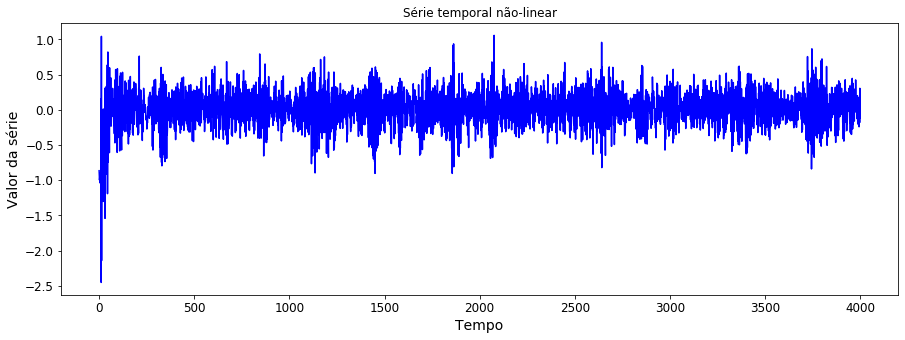

In [3]:
plt.figure(figsize=(15, 5));
plt.plot(series, color='blue', label='open')
plt.title('Série temporal não-linear')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')

### 6.4. Preparação da série temporal com linha de derivação de atraso, além de promover o particionamento entre conjuntos de treinamento, validação e teste

In [4]:
# function to create train, validation, test data given stock data and sequence length
def load_data(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-1]
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,1)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,1)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,1)
    
    np.savetxt('Q6P2_x_train.txt', x_train)
    np.savetxt('Q6P2_y_train.txt', y_train)
    np.savetxt('Q6P2_x_valid.txt', x_valid)
    np.savetxt('Q6P2_y_valid.txt', y_valid)
    np.savetxt('Q6P2_x_test.txt', x_test)
    np.savetxt('Q6P2_y_test.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# create train, test data
seq_len = 10 # Número de atrasos a serem considerados
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(series, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (3191, 10)
y_train.shape =  (3191, 1)
x_valid.shape =  (399, 10)
y_valid.shape =  (399, 1)
x_test.shape =  (399, 10)
y_test.shape =  (399, 1)


### 6.5. Visualização do comportamento da série temporal de teste

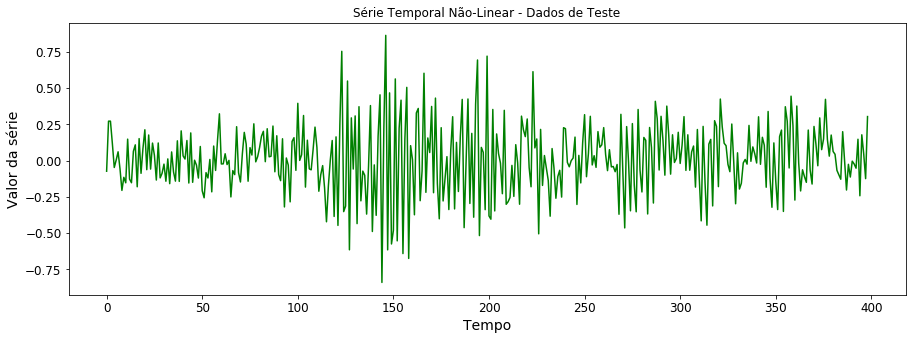

In [5]:
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='green')
plt.title('Série Temporal Não-Linear - Dados de Teste')
plt.xlabel('Tempo')
plt.ylabel('Valor da série')
plt.show()

### 6.6. Sintetizando um preditor linear

In [6]:
from sklearn.linear_model import LinearRegression

nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
lr = LinearRegression()
lr.fit(X, y_train)
w = lr.coef_[0]
print('Coeficientes do preditor linear')
print(w)

Coeficientes do preditor linear
[ 0.27299142  0.03401006 -0.18766307 -0.33875786  0.05451361  0.15593558
  0.22825877  0.44130719  0.05621329 -0.2540271   0.        ]


#### 6.6.1. Visualização do desempenho do preditor linear

In [7]:
from sklearn.metrics import mean_squared_error

print('EQM final de treinamento após o término do treinamento - Preditor Linear')
nr,nc = x_train.shape
B = np.ones((nr,1))
X = np.hstack((x_train,B))
y_pred = X.dot(w)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Linear')
nr,nc = x_valid.shape
B = np.ones((nr,1))
X = np.hstack((x_valid,B))
y_pred = X.dot(w)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Linear')
nr,nc = x_test.shape
B = np.ones((nr,1))
X = np.hstack((x_test,B))
y_pred = X.dot(w)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Linear
0.043909087273997685
EQM final de validação após o término do treinamento - Preditor Linear
0.03130168363162863
EQM final de teste após o término do treinamento - Preditor Linear
0.04225981520778723


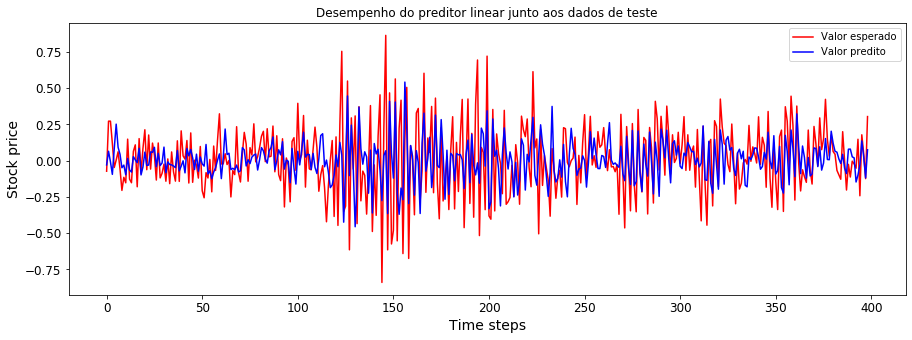

In [8]:
y_pred = X.dot(w)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor linear junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.7. Sintetizando um preditor não-linear MLP

In [9]:
EPOCHS = 100
np.random.seed(42)
tf.random.set_seed(42)

model_MLP = keras.models.Sequential([
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.tanh),
    keras.layers.Dense(64, activation=tf.nn.tanh),
    keras.layers.Dense(1)
])

model_MLP.compile(loss="mse", optimizer="adam")

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_MLP_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_MLP.fit(x_train, y_train, 
                        epochs=EPOCHS, 
                        validation_data=(x_valid, y_valid), 
                        callbacks=[earlystop, best_val], 
                        verbose=1)

Train on 3191 samples, validate on 399 samples
Epoch 1/100
3191/3191 [==============================] - 1s 316us/sample - loss: 0.0515 - val_loss: 0.0319
Epoch 2/100
3191/3191 [==============================] - 0s 67us/sample - loss: 0.0480 - val_loss: 0.0395
Epoch 3/100
3191/3191 [==============================] - 0s 72us/sample - loss: 0.0460 - val_loss: 0.0313
Epoch 4/100
3191/3191 [==============================] - 0s 64us/sample - loss: 0.0443 - val_loss: 0.0363
Epoch 5/100
3191/3191 [==============================] - 0s 69us/sample - loss: 0.0441 - val_loss: 0.0330
Epoch 6/100
3191/3191 [==============================] - 0s 72us/sample - loss: 0.0437 - val_loss: 0.0308
Epoch 7/100
3191/3191 [==============================] - 0s 66us/sample - loss: 0.0433 - val_loss: 0.0331
Epoch 8/100
3191/3191 [==============================] - 0s 71us/sample - loss: 0.0420 - val_loss: 0.0303
Epoch 9/100
3191/3191 [==============================] - 0s 64us/sample - loss: 0.0418 - val_loss: 0.032

3191/3191 [==============================] - 0s 70us/sample - loss: 0.0170 - val_loss: 0.0184
Epoch 78/100
3191/3191 [==============================] - 0s 84us/sample - loss: 0.0171 - val_loss: 0.0168
Epoch 79/100
3191/3191 [==============================] - 0s 79us/sample - loss: 0.0165 - val_loss: 0.0180
Epoch 80/100
3191/3191 [==============================] - 0s 73us/sample - loss: 0.0167 - val_loss: 0.0170
Epoch 81/100
3191/3191 [==============================] - 0s 69us/sample - loss: 0.0164 - val_loss: 0.0182
Epoch 82/100
3191/3191 [==============================] - 0s 71us/sample - loss: 0.0167 - val_loss: 0.0168
Epoch 83/100
3191/3191 [==============================] - 0s 84us/sample - loss: 0.0164 - val_loss: 0.0163
Epoch 84/100
3191/3191 [==============================] - 0s 66us/sample - loss: 0.0161 - val_loss: 0.0168
Epoch 85/100
3191/3191 [==============================] - 0s 66us/sample - loss: 0.0162 - val_loss: 0.0172
Epoch 86/100
3191/3191 [==========================

In [10]:
model_MLP.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1408      
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


#### 6.7.1. Carregando o modelo com o menor MAPE para o preditor MLP

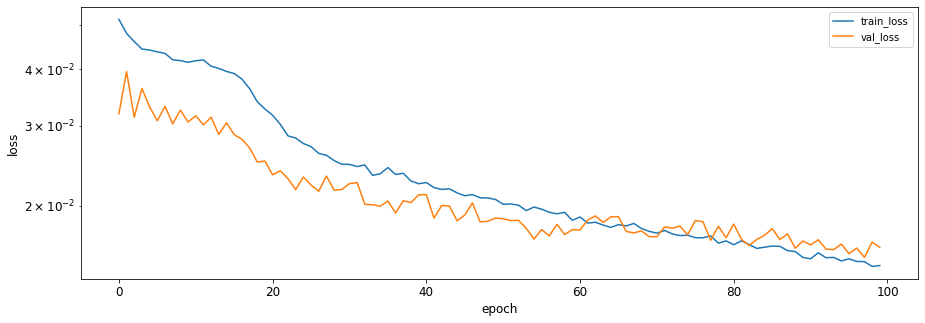

In [11]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_MLP.load_weights("model_MLP_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.7.2. Visualização do desempenho do preditor MLP

In [12]:
#weights = model_MLP.get_weights()
#print(weights)
print('EQM final de treinamento após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor MLP')
y_pred = model_MLP.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor MLP
0.013953224
EQM final de validação após o término do treinamento - Preditor MLP
0.0153656
EQM final de teste após o término do treinamento - Preditor MLP
0.020100448


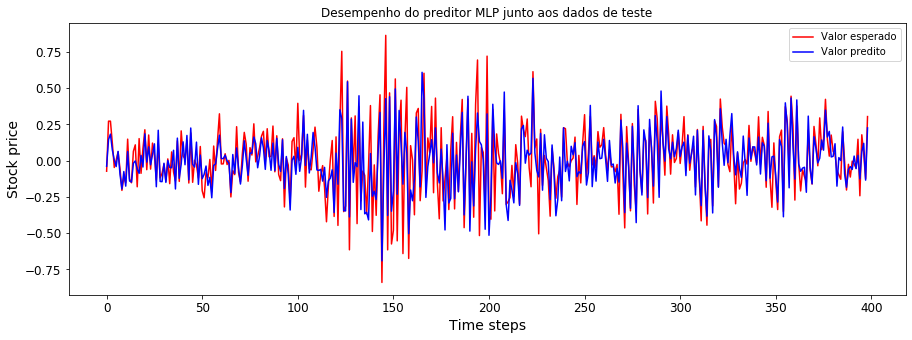

In [13]:
y_pred = model_MLP.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor MLP junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.8. Sintetizando um preditor não-linear Simple RNN

In [14]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN1 = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model_RNN1.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN1_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN1.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Train on 3191 samples, validate on 399 samples
Epoch 1/100
3191/3191 [==============================] - 3s 895us/sample - loss: 0.0603 - val_loss: 0.0308
Epoch 2/100
3191/3191 [==============================] - 1s 341us/sample - loss: 0.0454 - val_loss: 0.0307
Epoch 3/100
3191/3191 [==============================] - 1s 323us/sample - loss: 0.0437 - val_loss: 0.0288
Epoch 4/100
3191/3191 [==============================] - 1s 365us/sample - loss: 0.0418 - val_loss: 0.0286
Epoch 5/100
3191/3191 [==============================] - 1s 335us/sample - loss: 0.0400 - val_loss: 0.0290
Epoch 6/100
3191/3191 [==============================] - 1s 320us/sample - loss: 0.0384 - val_loss: 0.0254
Epoch 7/100
3191/3191 [==============================] - 1s 313us/sample - loss: 0.0374 - val_loss: 0.0271
Epoch 8/100
3191/3191 [==============================] - 1s 321us/sample - loss: 0.0352 - val_loss: 0.0242
Epoch 9/100
3191/3191 [======

Epoch 76/100
3191/3191 [==============================] - 1s 316us/sample - loss: 0.0187 - val_loss: 0.0192
Epoch 77/100
3191/3191 [==============================] - 1s 310us/sample - loss: 0.0183 - val_loss: 0.0198
Epoch 78/100
3191/3191 [==============================] - 1s 312us/sample - loss: 0.0183 - val_loss: 0.0170
Epoch 79/100
3191/3191 [==============================] - 1s 316us/sample - loss: 0.0179 - val_loss: 0.0197
Epoch 80/100
3191/3191 [==============================] - 1s 313us/sample - loss: 0.0178 - val_loss: 0.0180
Epoch 81/100
3191/3191 [==============================] - 1s 312us/sample - loss: 0.0178 - val_loss: 0.0186
Epoch 82/100
3191/3191 [==============================] - 1s 316us/sample - loss: 0.0178 - val_loss: 0.0177
Epoch 83/100
3191/3191 [==============================] - 1s 313us/sample - loss: 0.0177 - val_loss: 0.0182
Epoch 84/100
3191/3191 [==============================] - 1s 311us/sample - loss: 0.0180 - val_loss: 0.0176
Epoch 85/100
3191/3191 [====

In [15]:
model_RNN1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 20)          440       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 1,281
Trainable params: 1,281
Non-trainable params: 0
_________________________________________________________________


#### 6.8.1. Carregando o modelo com o menor MAPE para o preditor não-linear Simple RNN

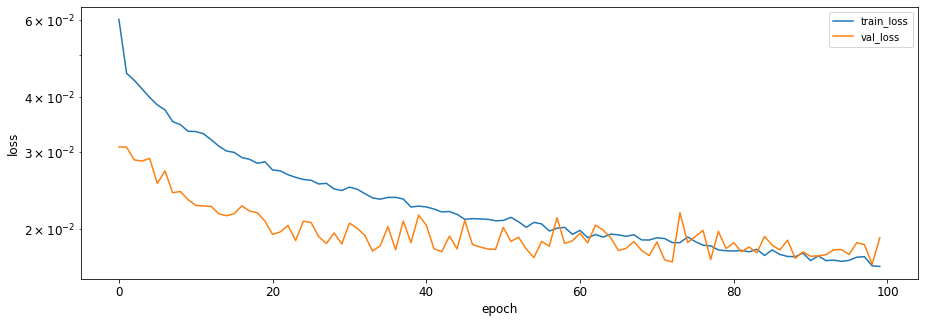

In [16]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN1.load_weights("model_RNN1_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.8.2. Visualização do desempenho do preditor não-linear Simple RNN junto aos dados de teste

In [17]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred = model_RNN1.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.0154403765
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.01658232
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.022741532


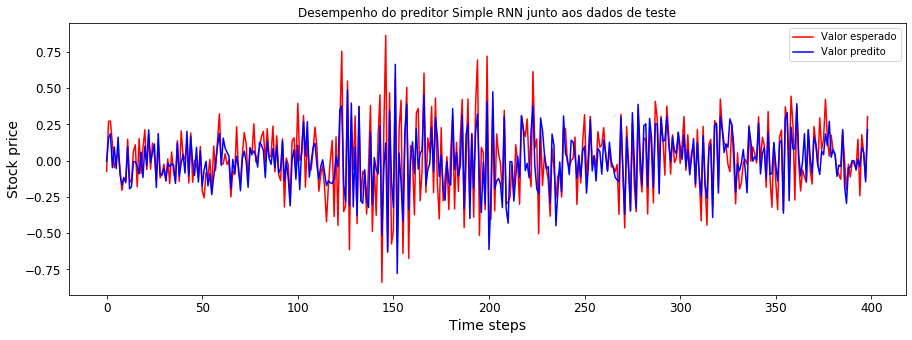

In [18]:
y_pred = model_RNN1.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.9. Sintetizando um preditor não-linear com bloco LSTM GRU

In [19]:
x_train = np.asarray(x_train)
if len(x_train.shape) < 3:
    x_train = np.expand_dims(x_train, axis=2)
y_train = np.asarray(y_train)
y_train = y_train.reshape(-1,1)
x_valid = np.asarray(x_valid)
if len(x_valid.shape) < 3:
    x_valid = np.expand_dims(x_valid, axis=2)
y_valid = np.asarray(y_valid)
y_valid = y_valid.reshape(-1,1)
x_test = np.asarray(x_test)
if len(x_test.shape) < 3:
    x_test = np.expand_dims(x_test, axis=2)
y_test = np.asarray(y_test)
y_test = y_test.reshape(-1,1)
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

np.random.seed(42)
tf.random.set_seed(42)

model_RNN2 = keras.models.Sequential([
    keras.layers.GRU(seq_len, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(seq_len, return_sequences=True),
    keras.layers.Dense(1)
])

model_RNN2.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN2_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN2.fit(x_train,
          y_train,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

(3191, 10, 1)
(3191, 1)
(399, 10, 1)
(399, 1)
(399, 10, 1)
(399, 1)
Train on 3191 samples, validate on 399 samples
Epoch 1/100
3191/3191 [==============================] - 5s 2ms/sample - loss: 0.0636 - val_loss: 0.0530
Epoch 2/100
3191/3191 [==============================] - 1s 176us/sample - loss: 0.0632 - val_loss: 0.0528
Epoch 3/100
3191/3191 [==============================] - 1s 162us/sample - loss: 0.0632 - val_loss: 0.0529
Epoch 4/100
3191/3191 [==============================] - 1s 165us/sample - loss: 0.0632 - val_loss: 0.0528
Epoch 5/100
3191/3191 [==============================] - 1s 162us/sample - loss: 0.0630 - val_loss: 0.0528
Epoch 6/100
3191/3191 [==============================] - 1s 164us/sample - loss: 0.0629 - val_loss: 0.0532
Epoch 7/100
3191/3191 [==============================] - 1s 163us/sample - loss: 0.0628 - val_loss: 0.0533
Epoch 8/100
3191/3191 [==============================] - 1s 159us/sample - loss: 0.0626 - val_loss: 0.0529
Epoch 9/100
3191/3191 [========

Epoch 76/100
3191/3191 [==============================] - 1s 161us/sample - loss: 0.0508 - val_loss: 0.0412
Epoch 77/100
3191/3191 [==============================] - 1s 161us/sample - loss: 0.0507 - val_loss: 0.0406
Epoch 78/100
3191/3191 [==============================] - 1s 169us/sample - loss: 0.0505 - val_loss: 0.0406
Epoch 79/100
3191/3191 [==============================] - 1s 167us/sample - loss: 0.0506 - val_loss: 0.0404
Epoch 80/100
3191/3191 [==============================] - 1s 169us/sample - loss: 0.0503 - val_loss: 0.0401
Epoch 81/100
3191/3191 [==============================] - 1s 169us/sample - loss: 0.0501 - val_loss: 0.0399
Epoch 82/100
3191/3191 [==============================] - 1s 161us/sample - loss: 0.0502 - val_loss: 0.0400
Epoch 83/100
3191/3191 [==============================] - 1s 167us/sample - loss: 0.0501 - val_loss: 0.0398
Epoch 84/100
3191/3191 [==============================] - 1s 170us/sample - loss: 0.0500 - val_loss: 0.0396
Epoch 85/100
3191/3191 [====

In [20]:
model_RNN2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 10)          660       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


#### 6.9.1. Carregando o modelo com o menor MAPE para o preditor não-linear com bloco LSTM GRU

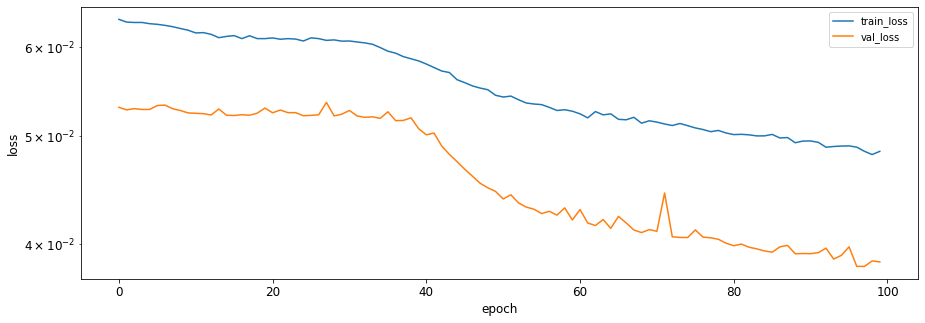

In [21]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN2.load_weights("model_RNN2_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.9.2. Visualização do desempenho do preditor não-linear com bloco LSTM GRU junto aos dados de teste

In [22]:
print('EQM final de treinamento após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_train,y_train)
print('EQM final de validação após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_valid,y_valid)
print('EQM final de teste após o término do treinamento - Preditor LSTM GRU')
model_RNN2.evaluate(x_test,y_test)

EQM final de treinamento após o término do treinamento - Preditor LSTM GRU
3191/1 [=====================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

EQM final de validação após o término do treinamento - Preditor LSTM GRU
399/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

EQM final de teste após o término do treinamento - Preditor LSTM GRU
399/1 [============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.04874387862426894

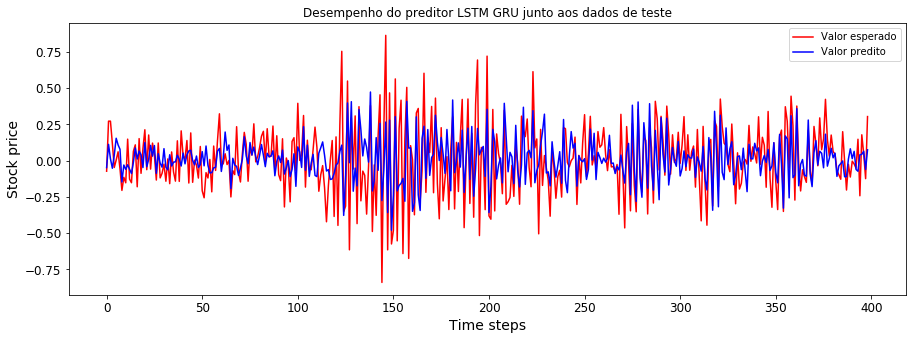

In [23]:
y_pred = model_RNN2.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred[:,seq_len-1], color='blue', label='Valor predito')
plt.title('Desempenho do preditor LSTM GRU junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

### 6.10. Sintetizando um preditor não-linear CNN 1D
#### Parcialmente baseado em https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/1_CNN_dilated.ipynb

In [24]:
from keras.layers import Conv1D, Dense, Flatten
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
model_CNN = Sequential()
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(seq_len, 1)))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model_CNN.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model_CNN.add(Flatten())
model_CNN.add(Dense(1, activation='linear'))
model_CNN.compile(optimizer='Adam', loss='mse')

In [25]:
model_CNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 10, 5)             15        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 176
Trainable params: 176
Non-trainable params: 0
_________________________________________________________________


In [26]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_CNN_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_CNN.fit(x_train,
          y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(x_valid, y_valid),
          callbacks=[earlystop, best_val],
          verbose=1)

Train on 3191 samples, validate on 399 samples
Epoch 1/100
3191/3191 [==============================] - 1s 193us/step - loss: 0.0633 - val_loss: 0.0414
Epoch 2/100
3191/3191 [==============================] - 0s 108us/step - loss: 0.0526 - val_loss: 0.0330
Epoch 3/100
3191/3191 [==============================] - 0s 102us/step - loss: 0.0471 - val_loss: 0.0309
Epoch 4/100
3191/3191 [==============================] - 0s 108us/step - loss: 0.0431 - val_loss: 0.0283
Epoch 5/100
3191/3191 [==============================] - 0s 108us/step - loss: 0.0405 - val_loss: 0.0267
Epoch 6/100
3191/3191 [==============================] - 0s 107us/step - loss: 0.0390 - val_loss: 0.0264
Epoch 7/100
3191/3191 [==============================] - 0s 110us/step - loss: 0.0379 - val_loss: 0.0258
Epoch 8/100
3191/3191 [==============================] - 0s 110us/step - loss: 0.0369 - val_loss: 0.0259
Epoch 9/100
3191/3191 [==============================] - 0s 111us/step - loss: 0.0363 - val_loss: 0.0249
Epoch 10

Epoch 78/100
3191/3191 [==============================] - 0s 106us/step - loss: 0.0268 - val_loss: 0.0214
Epoch 79/100
3191/3191 [==============================] - 0s 111us/step - loss: 0.0265 - val_loss: 0.0209
Epoch 80/100
3191/3191 [==============================] - 0s 112us/step - loss: 0.0263 - val_loss: 0.0219
Epoch 81/100
3191/3191 [==============================] - 0s 104us/step - loss: 0.0266 - val_loss: 0.0213
Epoch 82/100
3191/3191 [==============================] - 0s 107us/step - loss: 0.0264 - val_loss: 0.0220
Epoch 83/100
3191/3191 [==============================] - 0s 108us/step - loss: 0.0263 - val_loss: 0.0211
Epoch 84/100
3191/3191 [==============================] - 0s 107us/step - loss: 0.0265 - val_loss: 0.0211
Epoch 85/100
3191/3191 [==============================] - 0s 107us/step - loss: 0.0263 - val_loss: 0.0211
Epoch 86/100
3191/3191 [==============================] - 0s 113us/step - loss: 0.0266 - val_loss: 0.0211
Epoch 87/100
3191/3191 [======================

#### 6.10.1. Carregando o modelo com o menor MAPE para o preditor CNN

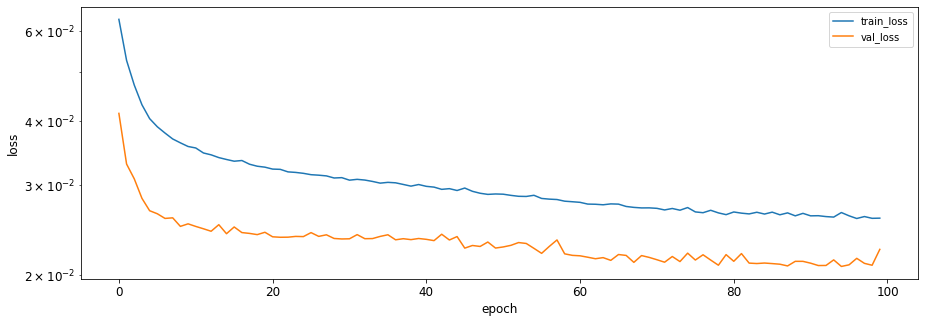

In [27]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_CNN.load_weights("model_CNN_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

#### 6.10.2. Visualização do desempenho do preditor CNN junto aos dados de teste

In [28]:
print('EQM final de treinamento após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_train)
MSE_train = mean_squared_error(y_train,y_pred)
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_valid)
MSE_valid = mean_squared_error(y_valid,y_pred)
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor CNN')
y_pred = model_CNN.predict(x_test)
MSE_test = mean_squared_error(y_test,y_pred)
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor CNN
0.025620406
EQM final de validação após o término do treinamento - Preditor CNN
0.020797545
EQM final de teste após o término do treinamento - Preditor CNN
0.02547282


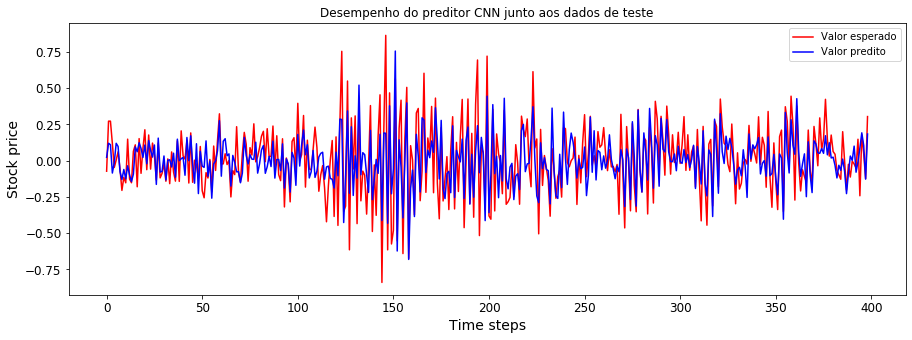

In [29]:
y_pred = model_CNN.predict(x_test)
plt.figure(figsize=(15, 5));
plt.plot(y_test, color='red', label='Valor esperado')
plt.plot(y_pred, color='blue', label='Valor predito')
plt.title('Desempenho do preditor CNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

## Análise dos resultados

### 6.2.1

Nessa parte 2 da questão, trabalhamos com uma série temporal estacionária e não-linear. Assim como na questão anterior, definimos um conjunto com sequências de valores. No caso da questão anterior, essa sequência era de 20 valores, já nessa parte utilizamos apenas 10 valores nesta sequência.

Dessa forma, implementamos o preditor linear para prever os dados de teste. Este modelo obteve um desempenho baixo, não conseguindo representar de forma satisfatória os valores esperados.

A seguir foram implementados os mesmos preditores não-lineares da questão anterior (MLP, Simple RNN, LSTM GRU e CNN 1D).

Esses modelos tiveram uma regularização na qual cada epoch de treinamento salvava um checkpoint do modelo e ao fim do treinamento, o epoch com o menor erro de validação era escolhido para a predição. Além disso, o professor também disponibilizou a função de EarlyStopping, o qual interrompe o treinamento quando o erro de validação não melhora após um número determinado de epochs.

### 6.2.2

Neste caso, utilizamos uma série estacionária e não-linear. Dessa forma, o preditor linear apresentou uma grande dificuldade de definir os pesos de cada valor da sequência e caracterizar o padrão de varições em torno do valor médio.

Já quando utilizamos um modelo não-linear para realizar a predição de uma serie não-linear, obtemos resultados mais satisfatórios, pois os modelos conseguem encontrar um padrão na sequencia de entrada e definir uma previsão mais próxima dos valores esperados.


### 6.2.3

Para implementar a predição de multiplos passos a frente, inicialmente, iremos editar a função load_data definida anteriormente. Nessa etapa iremos aumentar o valor de cada sequencia dos dados, onde a sequencia dos ultimos 10 valores irão ser categorizados com os y contento os proximos 5 valores.

In [39]:
def load_data_5(series, seq_len):
    data_raw = np.array(series) # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len - 1): 
        data.append(data_raw[index: index + seq_len + 1])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
        
    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-5:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-5:]
    
    x_test = data[train_set_size+valid_set_size:,:-1]
    y_test = data[train_set_size+valid_set_size:,-5:]
    
    
    x_train = np.asarray(x_train)
    y_train = np.asarray(y_train)
    y_train = y_train.reshape(-1,5)
    x_valid = np.asarray(x_valid)
    y_valid = np.asarray(y_valid)
    y_valid = y_valid.reshape(-1,5)
    x_test = np.asarray(x_test)
    y_test = np.asarray(y_test)
    y_test = y_test.reshape(-1,5)
    
    np.savetxt('Q6P2_x_train_5.txt', x_train)
    np.savetxt('Q6P2_y_train_5.txt', y_train)
    np.savetxt('Q6P2_x_valid_5.txt', x_valid)
    np.savetxt('Q6P2_y_valid_5.txt', y_valid)
    np.savetxt('Q6P2_x_test_5.txt', x_test)
    np.savetxt('Q6P2_y_test_5.txt', y_test)

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


seq_len = 10 # Número de atrasos a serem considerados
x_train_5, y_train_5, x_valid_5, y_valid_5, x_test_5, y_test_5 = load_data_5(series, seq_len)
print('x_train.shape = ',x_train_5.shape)
print('y_train.shape = ', y_train_5.shape)
print('x_valid.shape = ',x_valid_5.shape)
print('y_valid.shape = ', y_valid_5.shape)
print('x_test.shape = ', x_test_5.shape)
print('y_test.shape = ',y_test_5.shape)

x_train.shape =  (3191, 10)
y_train.shape =  (3191, 5)
x_valid.shape =  (399, 10)
y_valid.shape =  (399, 5)
x_test.shape =  (399, 10)
y_test.shape =  (399, 5)


In [40]:
x_train_5 = np.asarray(x_train_5)
if len(x_train_5.shape) < 3:
    x_train_5 = np.expand_dims(x_train_5, axis=2)
y_train_5 = np.asarray(y_train_5)
y_train_5 = y_train_5

x_valid_5 = np.asarray(x_valid_5)
if len(x_valid_5.shape) < 3:
    x_valid_5 = np.expand_dims(x_valid_5, axis=2)
y_valid_5 = np.asarray(y_valid_5)
y_valid_5 = y_valid_5


x_test_5 = np.asarray(x_test_5)
if len(x_test_5.shape) < 3:
    x_test_5 = np.expand_dims(x_test_5, axis=2)
y_test_5 = np.asarray(y_test_5)
y_test_5 = y_test_5


print(x_train_5.shape)
print(y_train_5.shape)
print(x_valid_5.shape)
print(y_valid_5.shape)
print(x_test_5.shape)
print(y_test_5.shape)

(3191, 10, 1)
(3191, 5)
(399, 10, 1)
(399, 5)
(399, 10, 1)
(399, 5)


A seguir iremos utilizar o modelo SimpleRNN, modificando apenas a ultima camada Dense. Trocando a predição de 1 valor para 5 valores. 

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model_RNN_m = keras.models.Sequential([
    keras.layers.SimpleRNN(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(10),
    keras.layers.Dense(5)
])

model_RNN_m.compile(loss="mse", optimizer="adam")
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=EPOCHS) # Se desejar early stopping, definir patience = 10
best_val = ModelCheckpoint('model_RNN_m_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)
history = model_RNN_m.fit(x_train_5,
          y_train_5,
          epochs=EPOCHS,
          validation_data=(x_valid_5, y_valid_5),
          callbacks=[earlystop, best_val],
          verbose=1)




Train on 3191 samples, validate on 399 samples
Epoch 1/100
3191/3191 [==============================] - 3s 1ms/sample - loss: 0.0865 - val_loss: 0.0283
Epoch 2/100
3191/3191 [==============================] - 1s 339us/sample - loss: 0.0353 - val_loss: 0.0163
Epoch 3/100
3191/3191 [==============================] - 1s 332us/sample - loss: 0.0249 - val_loss: 0.0119
Epoch 4/100
3191/3191 [==============================] - 1s 337us/sample - loss: 0.0191 - val_loss: 0.0093
Epoch 5/100
3191/3191 [==============================] - 1s 331us/sample - loss: 0.0157 - val_loss: 0.0081
Epoch 6/100
3191/3191 [==============================] - 1s 330us/sample - loss: 0.0138 - val_loss: 0.0075
Epoch 7/100
3191/3191 [==============================] - 1s 326us/sample - loss: 0.0128 - val_loss: 0.0072
Epoch 8/100
3191/3191 [==============================] - 1s 333us/sample - loss: 0.0122 - val_loss: 0.0069
Epoch 9/100
3191/3191 [==============================] - 1s 322us/sample - loss: 0.0117 - val_loss:

3191/3191 [==============================] - 1s 320us/sample - loss: 0.0078 - val_loss: 0.0055
Epoch 77/100
3191/3191 [==============================] - 1s 324us/sample - loss: 0.0078 - val_loss: 0.0055
Epoch 78/100
3191/3191 [==============================] - 1s 357us/sample - loss: 0.0078 - val_loss: 0.0053
Epoch 79/100
3191/3191 [==============================] - 1s 320us/sample - loss: 0.0077 - val_loss: 0.0054
Epoch 80/100
3191/3191 [==============================] - 1s 329us/sample - loss: 0.0077 - val_loss: 0.0053
Epoch 81/100
3191/3191 [==============================] - 1s 317us/sample - loss: 0.0077 - val_loss: 0.0054
Epoch 82/100
3191/3191 [==============================] - 1s 320us/sample - loss: 0.0077 - val_loss: 0.0055
Epoch 83/100
3191/3191 [==============================] - 1s 318us/sample - loss: 0.0077 - val_loss: 0.0053
Epoch 84/100
3191/3191 [==============================] - 1s 324us/sample - loss: 0.0077 - val_loss: 0.0059
Epoch 85/100
3191/3191 [=================

In [42]:
model_RNN_m.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


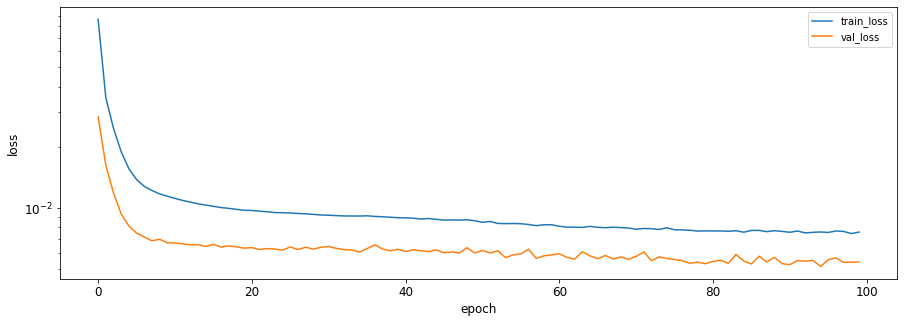

In [43]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model_RNN_m.load_weights("model_RNN_m_{:02d}.h5".format(best_epoch))
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [44]:
print('EQM final de treinamento após o término do treinamento - Preditor Simple RNN')
y_pred_5 = model_RNN_m.predict(x_train_5)
MSE_train = mean_squared_error(y_train_5[:,3],y_pred_5[:,3])
print(MSE_train)
print('EQM final de validação após o término do treinamento - Preditor Simple RNN')
y_pred_5 = model_RNN_m.predict(x_valid_5)
MSE_valid = mean_squared_error(y_valid_5[:,3],y_pred_5[:,3])
print(MSE_valid)
print('EQM final de teste após o término do treinamento - Preditor Simple RNN')
y_pred_5 = model_RNN_m.predict(x_test_5)
MSE_test = mean_squared_error(y_test_5[:,3],y_pred_5[:,3])
print(MSE_test)

EQM final de treinamento após o término do treinamento - Preditor Simple RNN
0.0003155234
EQM final de validação após o término do treinamento - Preditor Simple RNN
0.00016820325
EQM final de teste após o término do treinamento - Preditor Simple RNN
0.00019187928


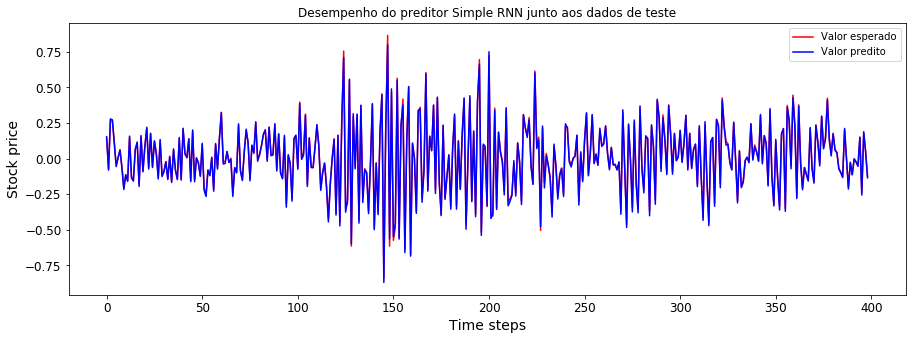

In [48]:
y_pred = model_RNN_m.predict(x_test_5)
plt.figure(figsize=(15, 5));
plt.plot(y_test_5[:,3], color='red', label='Valor esperado')
plt.plot(y_pred[:,3], color='blue', label='Valor predito')
plt.title('Desempenho do preditor Simple RNN junto aos dados de teste')
plt.xlabel('Time steps')
plt.ylabel('Stock price')
plt.legend(loc='best')
plt.show()

Ao fim do treinamento, podemos demonstrar graficamente os resultados da predição.

Os resultados prevendo 5 valores a frente tiveram a melhor performance até o momento. Apresentando o menor Erro Quadrático Médio, o modelo apresentou um resultado com uma grande aproximação aos valores esperados. 

### 6.2.4

Uma forma de “facilitar” o problema de uma série temporal não-estacionária, seria utilizar transformações matemáticas para “estacionarizar” a série, calculando a diferença de termos consecutivos na série, através da diferença sazonal, aplicando log, dentre outros métodos. Assim, com a série estacionária, as previsões serião realizadas com modelos não-lineares e depois inverter as transformações e obter as previsões para a série original.